In [9]:
%matplotlib inline

import sys
sys.path.append("../")
import scvi
from smFISHxscRNA.dataset import CortexDataset, SmfishDataset
from smFISHxscRNA.inference import VariationalInferenceFish
from smFISHxscRNA.models import VAEF
from smFISHxscRNA.metrics.clustering import get_data, get_common_t_sne, entropy_batch_mixing, get_estimated_values
from smFISHxscRNA.metrics.visualisation import show_cell_types, show_mixing, compare_cell_types, show_gene_exp, show_spatial_expression
from smFISHxscRNA.metrics.classification import cluster_accuracy_nn, cluster_accuracy_svc
from smFISHxscRNA.metrics.imputation import plot_correlation, proximity_imputation, compute_metrics, get_index, plot_imputation
import numpy as np
from smFISHxscRNA.train import train_FISHVAE_jointly


# Creating and training the model

In [3]:
genes_to_discard = ['gad2']
gene_dataset_fish = SmfishDataset()
gene_names = gene_dataset_fish.gene_names
l = []
for n_gene in range(len(gene_names)):
    for gene in genes_to_discard:
        if gene_names[n_gene].lower() == gene.lower():
            l.append(n_gene)
genes_to_discard = l
indexes_to_keep = np.arange(len(gene_names))
indexes_to_keep = np.delete(indexes_to_keep, genes_to_discard)
# The "genes_to_discard" argument is given here so that the order of the genes in CortexDataset matches
# the order in SmfishDataset

File data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
Preprocessing smFISH dataset
Finished preprocessing smFISH dataset


 We run with 200 additional genes for the scRNA-seq dataset

In [4]:
gene_dataset_seq = CortexDataset(genes_fish=gene_dataset_fish.gene_names, 
                                 genes_to_keep=["mog", "sst", "gja1", "ctss", "ndnf"], additional_genes=200)

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data


In [4]:
print(gene_dataset_seq.gene_names)
print(gene_dataset_fish.gene_names)

['GAD2' 'SLC32A1' 'CRHBP' 'CNR1' 'VIP' 'CPNE5' 'PTHLH' 'CRH' 'TBR1'
 'LAMP5' 'RORB' 'SYT6' 'KCNIP2' 'ALDOC' 'GFAP' 'SERPINF1' 'MFGE8' 'SOX10'
 'PLP1' 'PDGFRA' 'BMP4' 'ITPR2' 'TMEM2' 'CTPS' 'ANLN' 'MRC1' 'HEXB' 'TTR'
 'FOXJ1' 'VTN' 'FLT1' 'APLN' 'ACTA2' 'HTR3A' 'ALDOA' 'SYT1' 'NDNF' 'NPY'
 'SST' 'STMN3' 'NDUFA4' 'MDH1' 'SLC25A4' 'TUBB2A' 'TUBA1A' 'CST3'
 'CAMK2N1' 'SLC1A2' 'PCP4' 'SNAP25' 'CALM1' 'PPIA' 'SCG5' 'SNHG11' 'MEG3'
 'TTC3' 'HSP90AA1' 'SPARCL1' 'HSP90AB1' 'SNCA' 'ACTG1' 'ACTB' 'GPM6A'
 'DYNLL1' 'GSTP1' 'CHN1' 'CALM2' 'FTH1' 'TMSB4X' 'ATP1B1' 'RTN1' 'APP'
 'MAP1B' 'CPE' 'NRGN' 'PPP3CA' 'GRIA2' 'ATP2B1' 'PRKCB' 'KCTD12' 'MBP'
 'CNP' 'CD81' 'MOG' 'MALAT1' 'ENPP2' 'PTGDS' 'UGT8A' 'MAG' 'MAL' 'CAR2'
 'DBI' 'TRF' 'APOD' 'CTSS' 'HBB-B2' 'HBA-A2_LOC2' 'HBA-A2_LOC1' 'HBB-BS'
 'ATP1A2' 'GJA1' 'APOE']
['Gad2' 'Slc32a1' 'Crhbp' 'Cnr1' 'Vip' 'Cpne5' 'Pthlh' 'Crh' 'Tbr1'
 'Lamp5' 'Rorb' 'Syt6' 'Kcnip2' 'Aldoc' 'Gfap' 'Serpinf1' 'Mfge8' 'Sox10'
 'Plp1' 'Pdgfra' 'Bmp4' 'Itpr2' 'Tmem2' 'Ctps' 

In [5]:
vae = VAEF(gene_dataset_seq.nb_genes, indexes_to_keep, n_layers_decoder=2, n_latent=8,
           n_layers=2, n_hidden=256, reconstruction_loss='nb', dropout_rate=0.3, n_labels=7, n_batch=0, model_library=False)
infer = VariationalInferenceFish(vae, gene_dataset_seq, gene_dataset_fish, train_size=0.9, verbose=True, frequency=5, weight_decay=0.25)
infer.train(n_epochs=200, lr=0.001)
data_loader_fish = infer.data_loaders['train_fish']
data_loader_seq = infer.data_loaders['train_seq']
# train_FISHVAE_jointly(vae, data_loader_seq, data_loader_fish, lr=0.01, n_epochs=200, weight_decay=0.25)


EPOCH [0/200]: 
LL for train_seq is : 926.7209
LL for test_seq is : 921.0391
LL for train_fish is : 229.7055
LL for test_fish is : 247.4283

EPOCH [5/200]: 
LL for train_seq is : 782.2425
LL for test_seq is : 774.3015
LL for train_fish is : 142.8887
LL for test_fish is : 145.0373

EPOCH [10/200]: 
LL for train_seq is : 680.1591
LL for test_seq is : 670.9827
LL for train_fish is : 131.1425
LL for test_fish is : 133.2500

EPOCH [15/200]: 
LL for train_seq is : 657.8703
LL for test_seq is : 649.6528
LL for train_fish is : 128.7679
LL for test_fish is : 130.1916

EPOCH [20/200]: 
LL for train_seq is : 656.6505
LL for test_seq is : 646.7531
LL for train_fish is : 127.2765
LL for test_fish is : 129.4705

EPOCH [25/200]: 
LL for train_seq is : 651.3403
LL for test_seq is : 642.8953
LL for train_fish is : 124.5096
LL for test_fish is : 126.8922

EPOCH [30/200]: 
LL for train_seq is : 641.5698
LL for test_seq is : 632.8819
LL for train_fish is : 122.9999
LL for test_fish is : 125.4521

EPOCH [

In [ ]:
infer.train(n_epochs=50, lr=0.001)




EPOCH [0/50]: 
LL for train_seq is : 607.2508
LL for test_seq is : 598.2687
LL for train_fish is : 114.4526
LL for test_fish is : 115.1745

EPOCH [5/50]: 
LL for train_seq is : 606.9860
LL for test_seq is : 597.8495
LL for train_fish is : 113.2567
LL for test_fish is : 113.6873

EPOCH [10/50]: 
LL for train_seq is : 605.7240
LL for test_seq is : 596.7365
LL for train_fish is : 116.1225
LL for test_fish is : 117.4377

EPOCH [15/50]: 
LL for train_seq is : 612.7870
LL for test_seq is : 602.5598
LL for train_fish is : 113.8603
LL for test_fish is : 113.9047

EPOCH [20/50]: 
LL for train_seq is : 607.2873
LL for test_seq is : 597.3001
LL for train_fish is : 113.3945
LL for test_fish is : 114.7018

EPOCH [25/50]: 
LL for train_seq is : 608.1423
LL for test_seq is : 600.6372
LL for train_fish is : 112.1503
LL for test_fish is : 112.1294

EPOCH [30/50]: 
LL for train_seq is : 604.9992
LL for test_seq is : 596.3979
LL for train_fish is : 116.2650
LL for test_fish is : 117.0265

EPOCH [35/50]:

In [6]:
data_loader_fish = infer.data_loaders['train_fish']
data_loader_seq = infer.data_loaders['train_seq']
# Getting data of interest
latent_seq, _, labels_seq, expected_frequencies_seq, values_seq = get_data(vae, data_loader_seq, mode="scRNA")
latent_fish, _, labels_fish, expected_frequencies_fish, values_fish, x_coords, y_coords = get_data(vae, data_loader_fish, mode="smFISH")

# 1. Imputation

## Our method: Imputed counts vs real counts for unobserved (during training) smFISH gene 

In [7]:
est_fish, real_fish = get_estimated_values(vae, data_loader_fish, mode="smFISH")
imputed = expected_frequencies_fish[:, 0] 
imputed = imputed / np.sum(expected_frequencies_fish[:, vae.indexes_to_keep], axis=1).ravel()
imputed *= np.sum(values_fish[:, vae.indexes_to_keep], axis=1)


../smFISHxscRNA/metrics/imputation.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, _, _, _ = np.linalg.lstsq(y[:, np.newaxis], x)


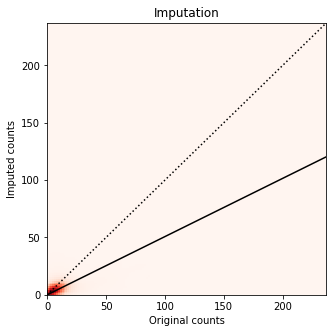

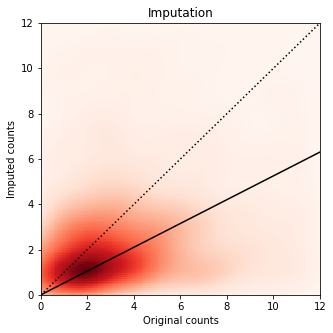

In [10]:
mean = np.mean(values_fish[:, 0])
to_keep = [idx for idx in range(len(values_fish[:, 0])) if values_fish[idx, 0]<mean]
plot_imputation(imputed, values_fish[:, 0])
plot_imputation(imputed[to_keep], values_fish[to_keep, 0]) # zooming on the highest density region


## Benchmark: Imputed counts vs real counts for unobserved (during training) smFISH gene 

In [ ]:
# Getting data for benchmark
concatenated_matrix = np.concatenate((gene_dataset_fish.X[:, 1:], gene_dataset_seq.X[:, :(len(gene_dataset_fish.gene_names)-1)]))
concatenated_matrix = np.log(1 + concatenated_matrix)
PCA_labels = gene_dataset_fish.labels.ravel()
PCA_labels_reg = gene_dataset_seq.labels.ravel()
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
latent_pca = pca.fit_transform(concatenated_matrix)
PCA_latent_fish = latent_pca[:gene_dataset_fish.X.shape[0], :]
PCA_latent_seq = latent_pca[gene_dataset_fish.X.shape[0]:, :]
PCA_values_seq = gene_dataset_seq.X
PCA_values_fish = gene_dataset_fish.X
PCA_labels_seq = gene_dataset_seq.labels
PCA_labels_fish = gene_dataset_fish.labels

../smFISHxscRNA/metrics/imputation.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, _, _, _ = np.linalg.lstsq(y[:, np.newaxis], x)


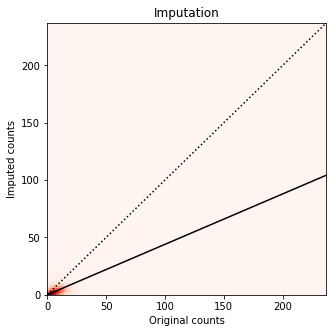

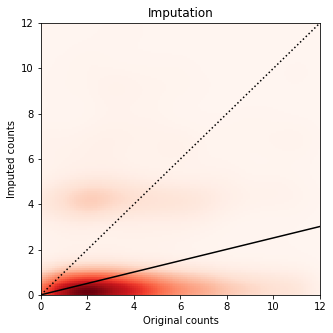

In [221]:
predicted_PCA = proximity_imputation(PCA_latent_seq, PCA_values_seq[:, 0], PCA_latent_fish, k=5)

# plot_correlation(PCA_values_fish[:, 0], predicted_PCA)
mean = np.mean(PCA_values_fish[:, 0])
to_keep = [idx for idx in range(len(PCA_values_fish[:, 0])) if PCA_values_fish[idx, 0]<mean]
plot_imputation(predicted_PCA, PCA_values_fish[:, 0])
plot_imputation(predicted_PCA[to_keep], PCA_values_fish[to_keep, 0]) # zooming on the highest density region

# Getting a common meaningful representation

In [11]:
t_sne_seq, t_sne_fish, idx_t_sne_seq, idx_t_sne_fish = get_common_t_sne(latent_seq, latent_fish, n_samples=1000)


## Our method: Embedding of the two datasets in the shared latent space

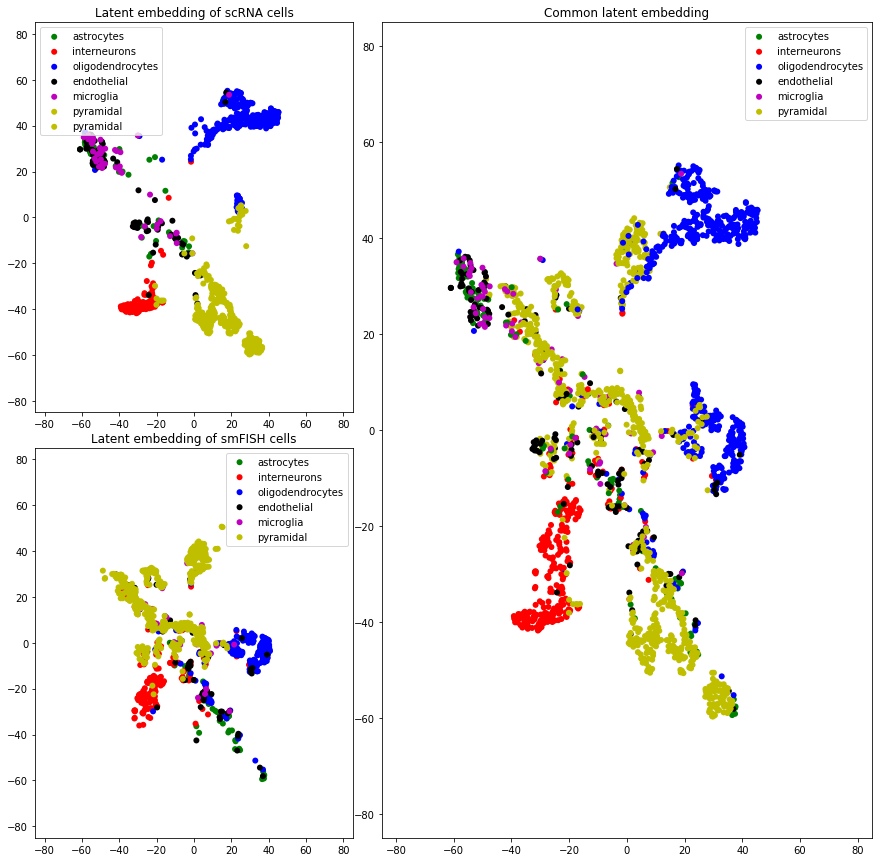

<Figure size 432x288 with 0 Axes>

In [12]:
show_cell_types(t_sne_seq, labels_seq[idx_t_sne_seq], t_sne_fish, labels_fish[idx_t_sne_fish])


## Benchmark: Embedding of the two datasets in the shared latent space

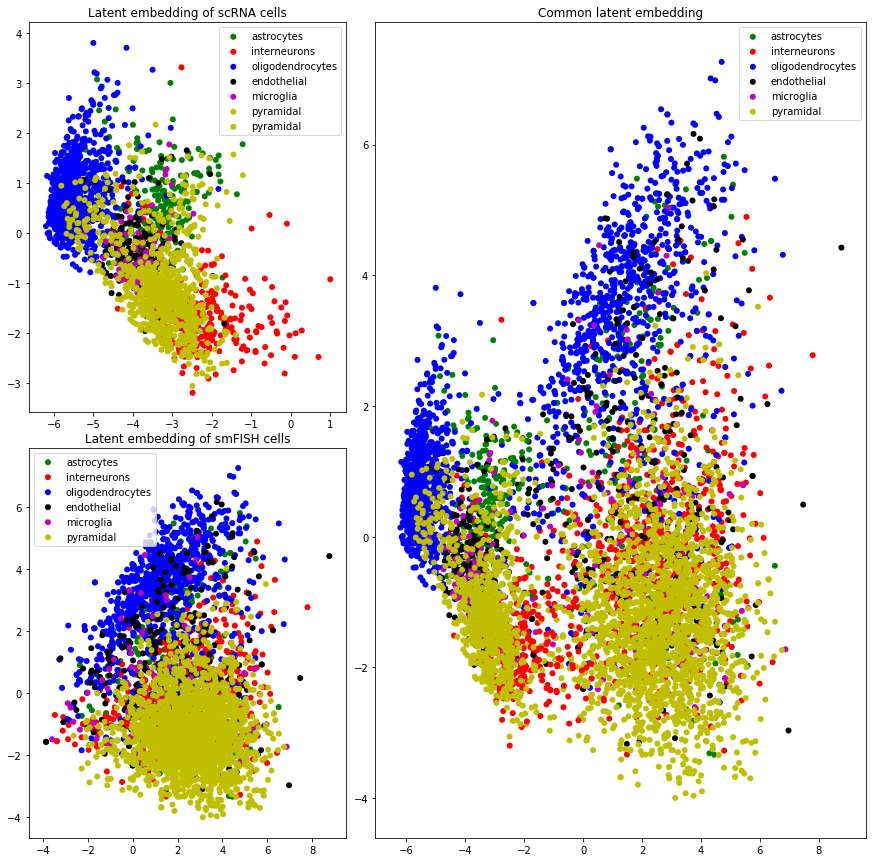

<Figure size 432x288 with 0 Axes>

In [172]:
show_cell_types(PCA_latent_seq[:, :2], PCA_labels_seq.ravel(), PCA_latent_fish[:, :2], PCA_labels_fish.ravel(), x_lim=None)


## How well do the datasets mix in the latent space?

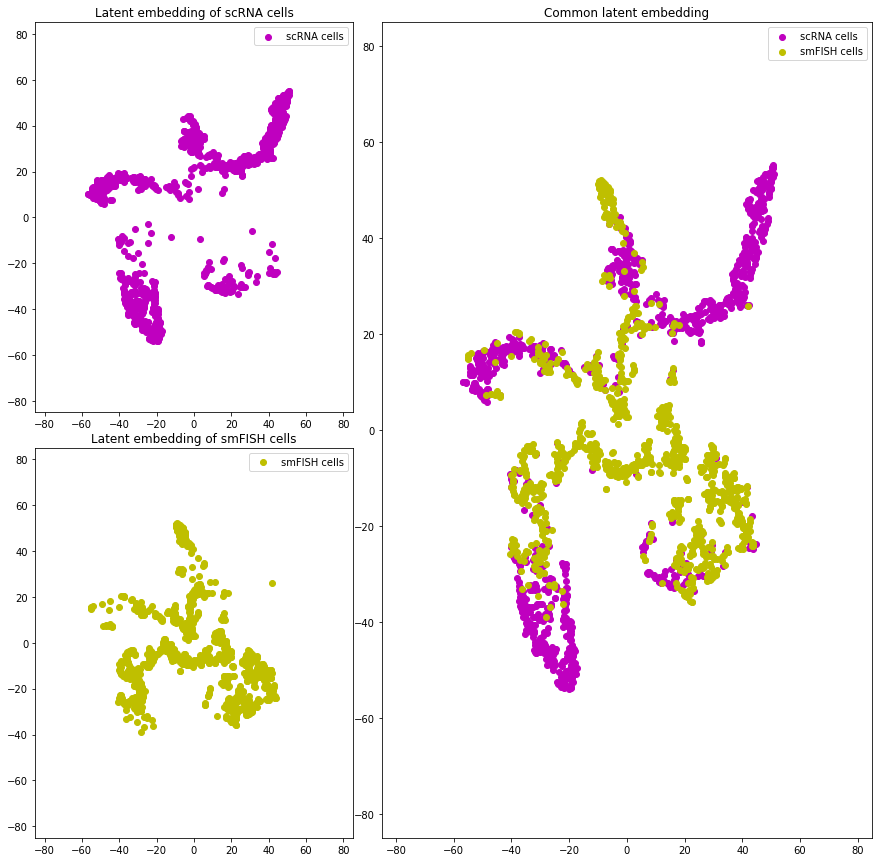

0.3953557951412088


<Figure size 432x288 with 0 Axes>

In [173]:
show_mixing(t_sne_seq, t_sne_fish)
print(entropy_batch_mixing(np.concatenate((t_sne_seq, t_sne_fish)),
                           batches=np.concatenate((np.zeros_like(idx_t_sne_seq),
                                                  np.ones_like(idx_t_sne_fish)))))

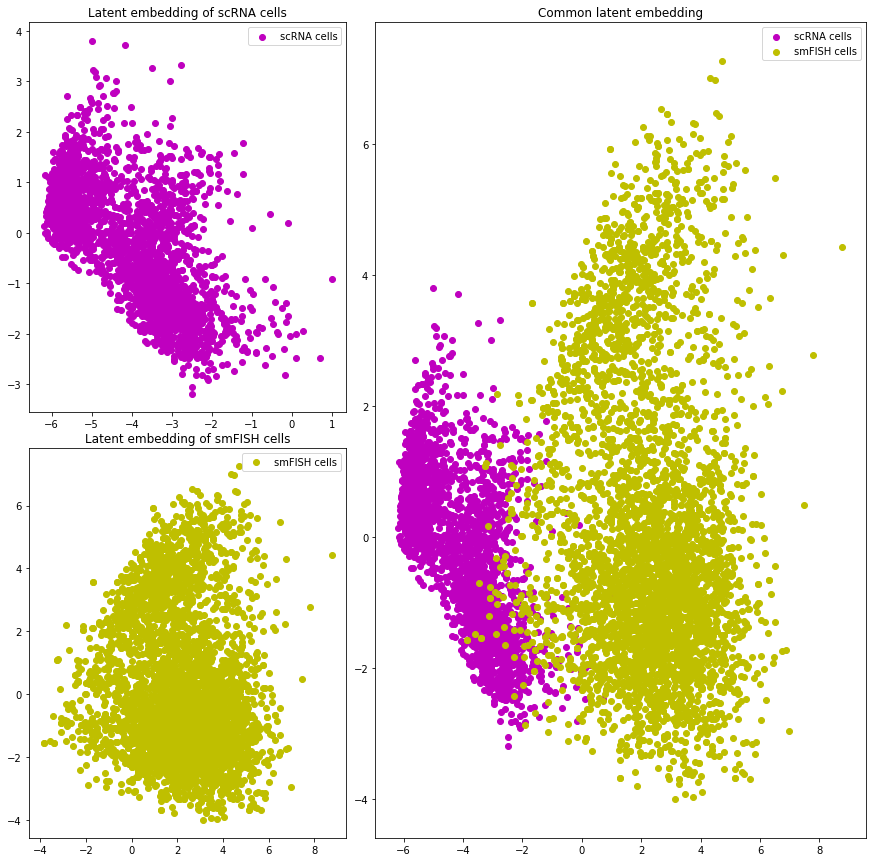

0.07890854942690337


<Figure size 432x288 with 0 Axes>

In [174]:
show_mixing(PCA_latent_seq[:, :2], PCA_latent_fish[:, :2], x_lim=None)
print(entropy_batch_mixing(np.concatenate((PCA_latent_seq[:, :2], PCA_latent_fish[:, :2])),
                           batches=np.concatenate((np.zeros_like(PCA_latent_seq[:, :2]),
                                                  np.ones_like(PCA_latent_fish[:, :2])))))

# Classifying cells in different cell types

In [183]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


def cluster_svc(frequencies1, label1, frequencies2):
    svc = SVC()
    parameters = {'kernel':('linear', 'rbf'), 'C': [1, 100], 'class_weight': ['balanced']}
    clf = GridSearchCV(svc, parameters)
    clf.fit(frequencies1, label1)
    inferred_labels = clf.predict(frequencies2)
    return inferred_labels


def cluster_accuracy_svc(frequencies1, label1, frequencies2, label2):
    inferred_labels = cluster_svc(frequencies1, label1, frequencies2)
    for label in range(inferred_labels.shape[0]):
        if inferred_labels[label] == 6:
            inferred_labels[label] = 5
    clustering_accuracy = np.mean(inferred_labels == label2)*100
    return clustering_accuracy, inferred_labels


In [189]:
accuracy_svc, inferred_labels_svc = cluster_accuracy_svc(expected_frequencies_seq, labels_seq, expected_frequencies_fish, labels_fish)
accuracy, inferred_labels = cluster_accuracy_nn(latent_seq, labels_seq, latent_fish, labels_fish, k=1)
PCA_accuracy, PCA_inferred_labels = cluster_accuracy_nn(PCA_latent_seq, PCA_labels_seq.ravel(), PCA_latent_fish, PCA_labels_fish.ravel())


Accuracy and PCA_accuracy: KNN classifier based on our latent space and the baseline's latent space.                    
Accuracy_svc: obtained using a SVC classifier trained on the predicted expected frequencies for the counts 

In [192]:
print(accuracy)
print(PCA_accuracy)
print(accuracy_svc)

51.70610211706103
55.44598834603317
62.76463262764632


## Inferred vs real labels

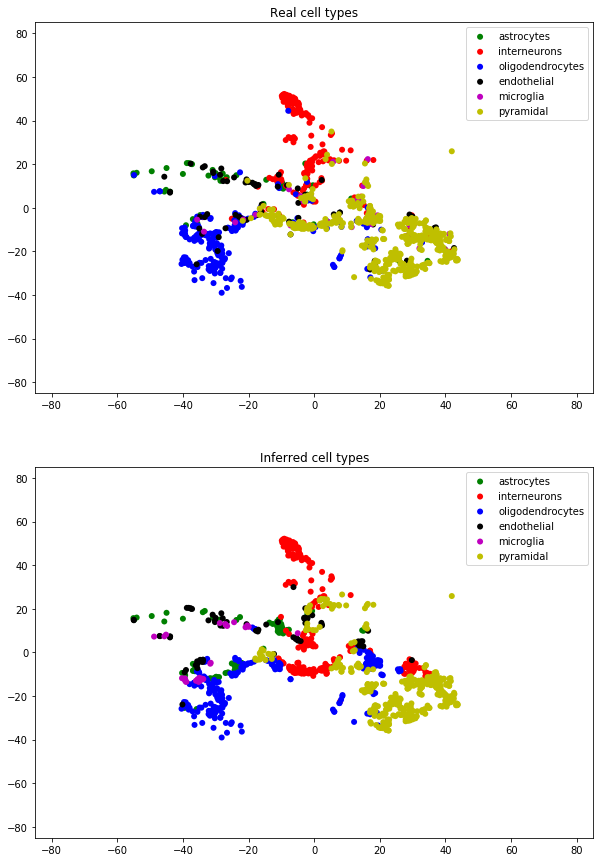

<Figure size 432x288 with 0 Axes>

In [178]:
compare_cell_types(t_sne_fish, labels_fish[idx_t_sne_fish], inferred_labels[idx_t_sne_fish])


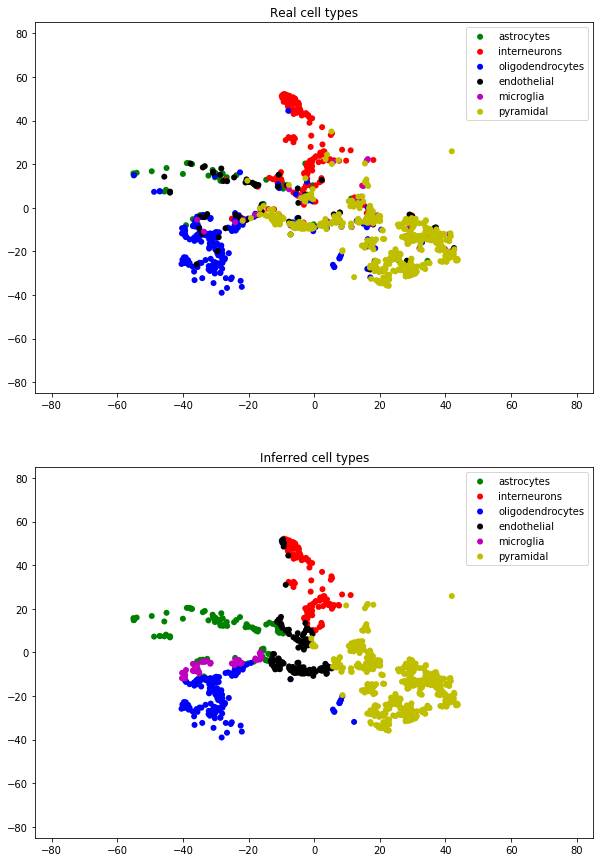

<Figure size 432x288 with 0 Axes>

In [179]:
compare_cell_types(t_sne_fish, labels_fish[idx_t_sne_fish], inferred_labels_svc[idx_t_sne_fish])


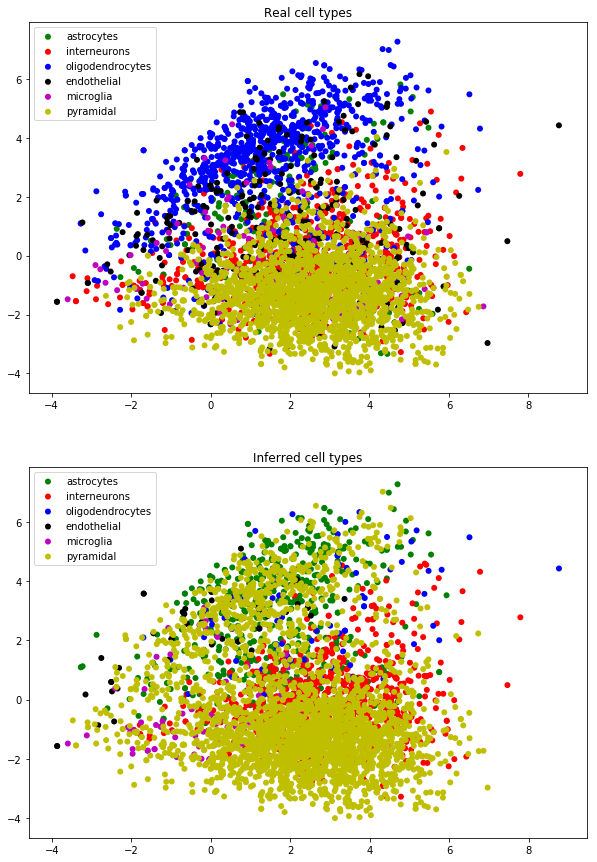

<Figure size 432x288 with 0 Axes>

In [193]:
compare_cell_types(PCA_latent_fish[:, :2], PCA_labels_fish.ravel(), PCA_inferred_labels, x_lim=None)


# Imputing unobserved genes for the smFISH experiment

We impute marker genes for different cell types, to ensure the consistency of our model

In [225]:

idx_to_impute = get_index(gene_dataset_seq.gene_names, "gad2")
idx_astro = get_index(gene_dataset_seq.gene_names, "gja1")
idx_oligo = get_index(gene_dataset_seq.gene_names, "mog")
idx_interneurons = get_index(gene_dataset_seq.gene_names, "sst")




Found idx 0 for gene gad2!
Found idx 225 for gene gja1!
Found idx 199 for gene mog!
Found idx 55 for gene sst!


## Astrocytes marker gene imputation

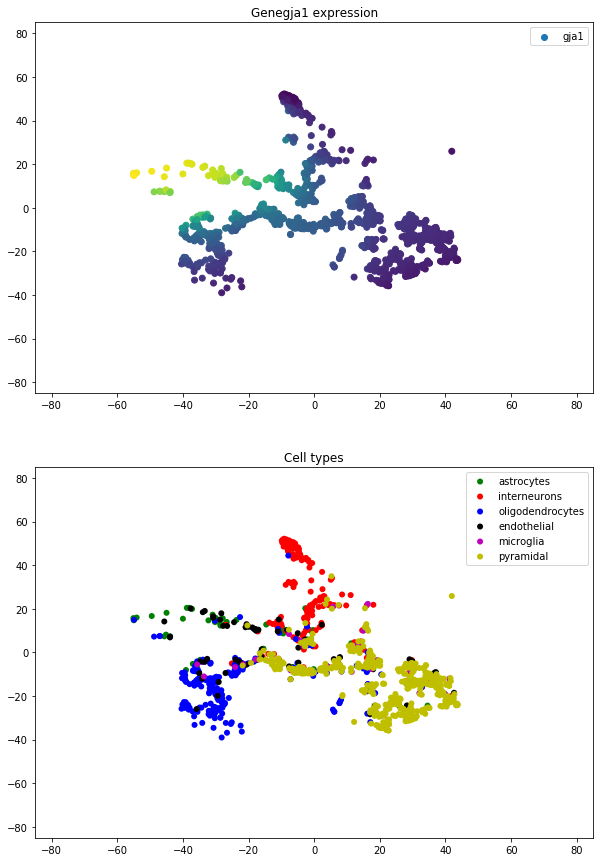

<Figure size 432x288 with 0 Axes>

In [197]:
show_gene_exp(t_sne_fish, expected_frequencies_fish[idx_t_sne_fish, idx_astro], labels=labels_fish[idx_t_sne_fish],
              title="latent_exp_astro.svg", gene_name="gja1")

## Oligodendrocytes marker gene imputation
This marker gene defines a finer cell type within the astrocytes population. Here, we see a clear gradient of expression for this gene.   

Imputation of refined cell types marker gene is a feature that could help us get a more precise spatial map of cell types 

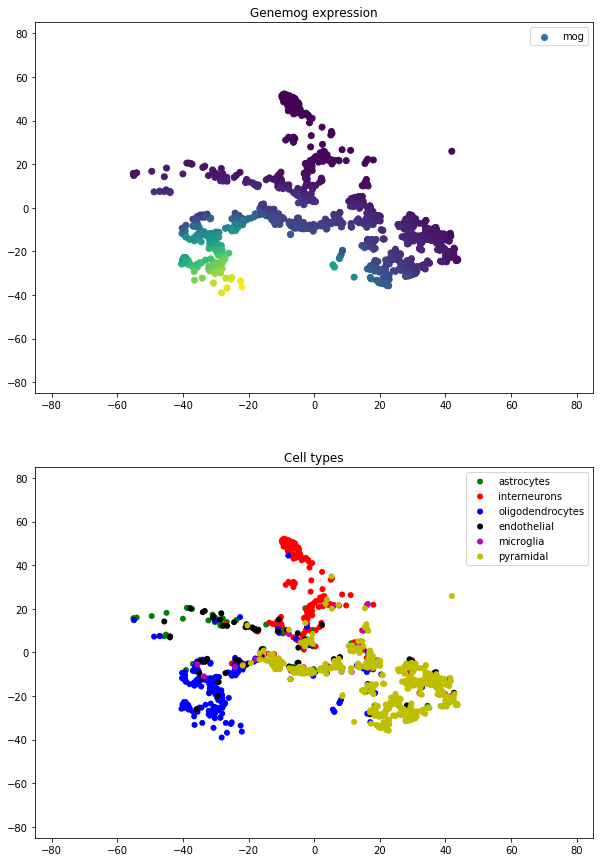

<Figure size 432x288 with 0 Axes>

In [198]:
show_gene_exp(t_sne_fish, expected_frequencies_fish[idx_t_sne_fish, idx_oligo], labels=labels_fish[idx_t_sne_fish],
              title="latent_exp_oligo.svg", gene_name="mog")

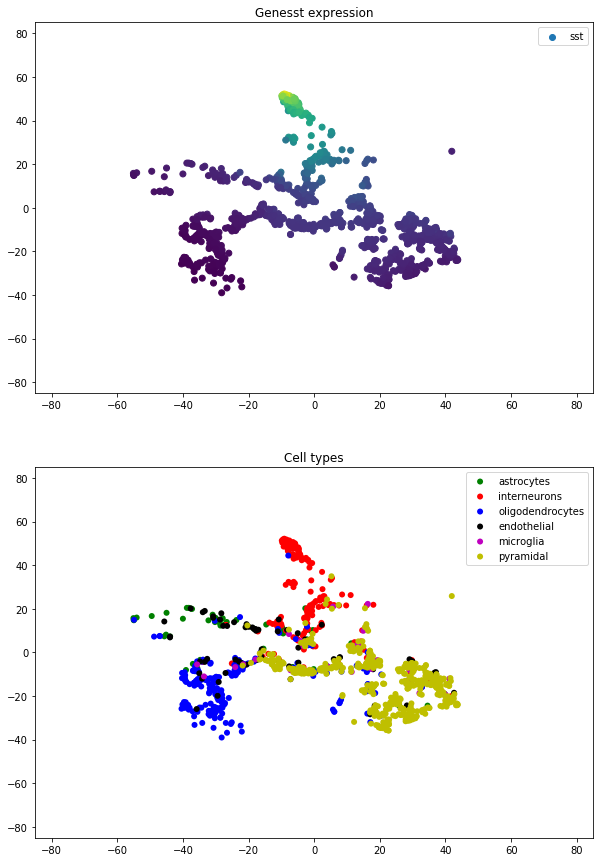

<Figure size 432x288 with 0 Axes>

In [199]:
show_gene_exp(t_sne_fish, expected_frequencies_fish[idx_t_sne_fish, idx_interneurons], labels=labels_fish[idx_t_sne_fish],
              title="latent_exp_interneurons.svg", gene_name="sst")

## Spatial imputation

Now that we can impute values for smFISH cells, we can estimate a spatial map for the gene expression of genes sequenced with scRNA-seq

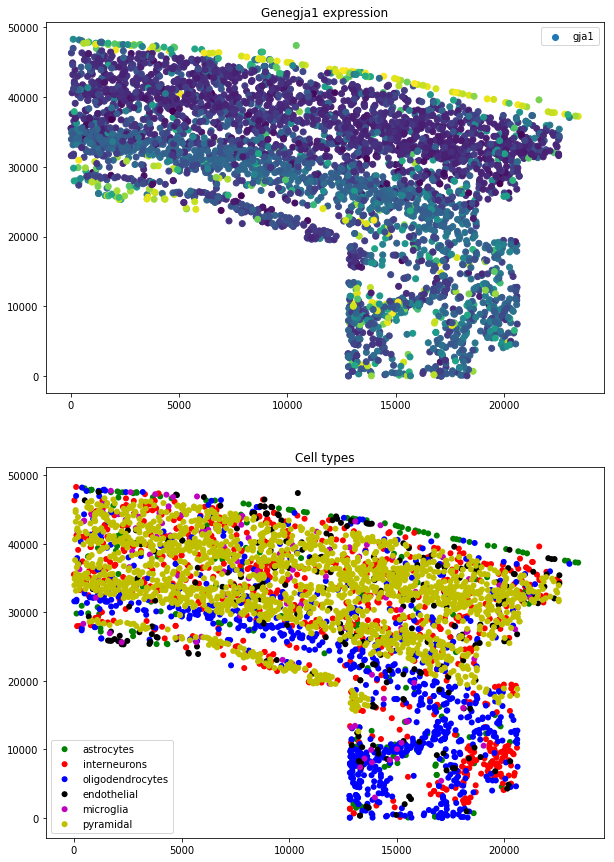

<Figure size 432x288 with 0 Axes>

In [200]:
show_spatial_expression(x_coords, y_coords,
                        expected_frequencies_fish[:, idx_astro], labels=labels_fish,
                        title="spatial_exp_astro.svg", gene_name="gja1")

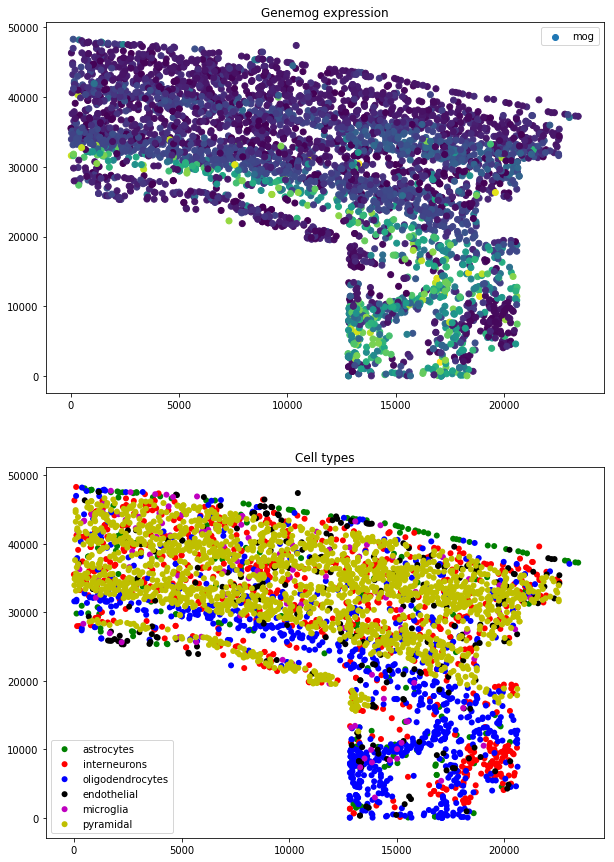

<Figure size 432x288 with 0 Axes>

In [202]:
show_spatial_expression(x_coords, y_coords,
                        expected_frequencies_fish[:, idx_oligo], labels=labels_fish,
                        title="spatial_exp_oligo.svg", gene_name="mog")

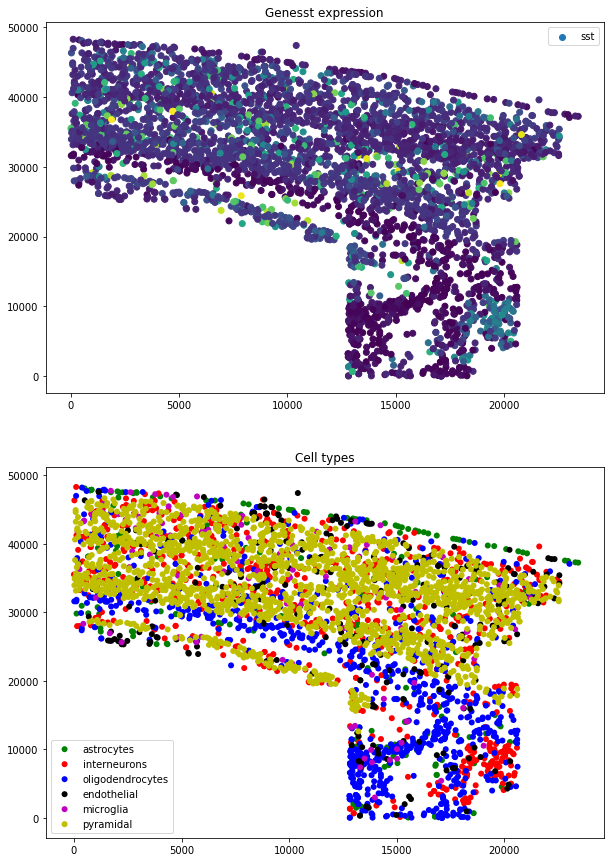

<Figure size 432x288 with 0 Axes>

In [204]:
show_spatial_expression(x_coords, y_coords,
                        expected_frequencies_fish[:, idx_interneurons],
                        labels=labels_fish, title="spatial_exp_interneurons.svg", gene_name="sst")